# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, I provide my solution using DDPG algorithm to solve Unity's Reacher environment.

### 1. Import the Necessary Packages

In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from unityagents import UnityEnvironment
from ddpg_agent import Agent

%matplotlib inline

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


### 2. Instantiate the Environment and Agent

In [2]:
env = UnityEnvironment(file_name='Reacher_20.app')
agent = Agent(state_size=33, action_size=4, random_seed=2)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# get the number of agents in the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# show computation device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
cuda:0


### 3. Train the Agent with DDPG

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 50	Average Score: 2.96
Episode 100	Average Score: 10.54
Episode 150	Average Score: 18.42
Episode 200	Average Score: 35.07
Environment solved in 200 episodes. Final adverage score: 35.07


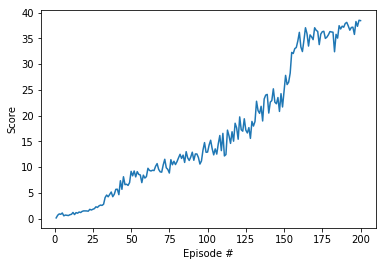

In [3]:
def ddpg(n_episodes=500, max_t=1000, print_every=50):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(1, max_t+1):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.memorize(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if t%20==0:
                for _ in range(10):
                    agent.learn()
            if np.any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 35:
            print('Environment solved in {} episodes. Final adverage score: {:.2f}'
                  .format(i_episode, np.mean(scores_deque)))
            break
            
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Evaluate the performance of a trained agent

In [5]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
env.close()

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Total score (averaged over agents) this episode: 36.71399917937815
